In [ ]:
!git clone https://github.com/pytorch/captum.git
%cd captum
!pip install -e 

Cloning into 'captum'...
remote: Enumerating objects: 22393, done.
remote: Counting objects: 100% (1045/1045), done.
remote: Compressing objects: 100% (387/387), done.
remote: Total 22393 (delta 512), reused 892 (delta 411), pack-reused 21348
Receiving objects: 100% (22393/22393), 251.51 MiB | 39.83 MiB/s, done.
Resolving deltas: 100% (13754/13754), done.
/content/captum

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 37.2 MB/s 


In [ ]:
!pip install scikit-plot
import scikitplot as skplt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchviz

In [ ]:
import numpy as np
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import Image

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.models import vgg19
from torchsummary import summary
from tqdm import tqdm

In [ ]:
# Import Captum
from captum.attr import Saliency
from captum.attr import visualization as vis
from captum.attr import (
	  GuidedBackprop,
	  Occlusion,
	  Saliency,
	  IntegratedGradients,
		GradientShap,
		Deconvolution,
		DeepLift,
		LRP,
		Lime,
    DeepLiftShap,
		GuidedGradCam
	)

In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from torch import Tensor

In [ ]:
torch.cuda.is_available()

True

In [ ]:
cuda = torch.device('cuda')

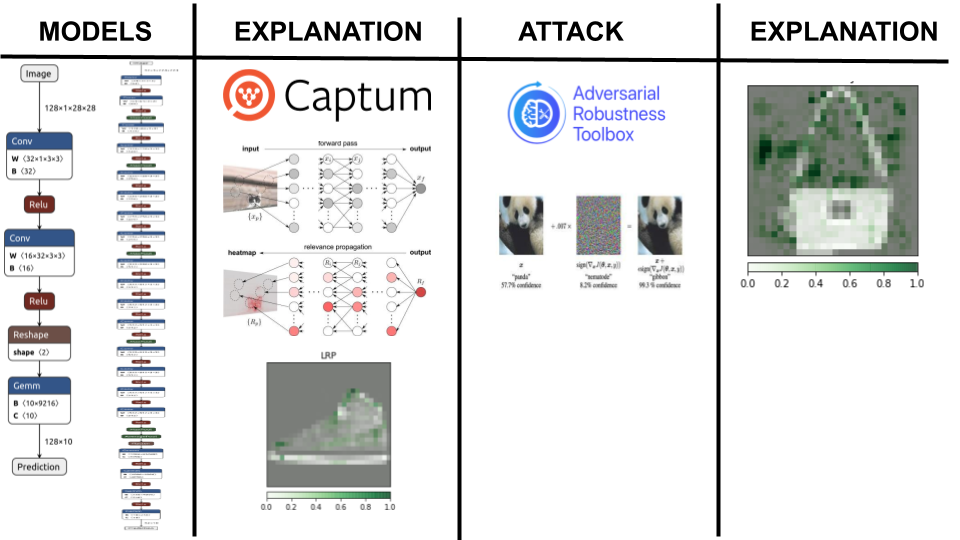

In [1]:
Image('/content/Deeplearning_overview.png')

In [ ]:
# Download and prepare training and test data.
# Download and prepare training and test data.
	
training_data = datasets.FashionMNIST(
	  root="data",
	  train=True,	
    download=True,	
    transform = transforms.Compose([transforms.ToTensor(),])	
)
	
test_data = datasets.FashionMNIST(	
    root="data",	
    train=False,	
    download=True,	
    transform=transforms.Compose([transforms.ToTensor(),])	
)
	
train_data_loader = DataLoader(training_data, batch_size=128)
	
test_data_loader = DataLoader(test_data, batch_size=128)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
#simple CNN Model for Fashion MNIST (with 2 convolutional layers)
class FashionNetwork(nn.Module):
	
    def __init__(self):
        super(FashionNetwork, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1)
        self.conv_2 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1)
        self.drop = nn.Dropout(0.25)
        self.lin1 = nn.Linear(in_features=16*24*24,out_features=10)   
	
    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.conv_2(x)
        x = F.relu(x)
        x = self.drop(x)

        x = x.reshape(-1,16*24*24)
        x = self.lin1(x)


        return x
	

In [ ]:
#train Fashion MNIST model
def train_loop(data_loader, model, loss_function, optimizer):
  loop = tqdm(data_loader)
  for batch, (data, labels) in enumerate(loop):
    data = data.to(cuda)
    labels = labels.to(cuda)
    # Feed data through network and compute loss.
    prediction = model(data)
    loss = loss_function(prediction, labels)

    # Zero gradients.
    optimizer.zero_grad()
 
    # Perform backpropagation and accumulate gradients.
    loss.backward()

    # Update network parameters.
    optimizer.step()
    loop.set_postfix(loss=torch.rand(1).item(), acc=torch.rand(1).item())
	

In [ ]:
def test_loop(data_loader, model, loss_function):
  n_samples = len(data_loader.dataset)
  n_batches = len(data_loader)
  
  loss, n_correct = 0, 0
		
  with torch.no_grad():
    for data, labels in data_loader:
      data = data.to(cuda)
      labels = labels.to(cuda)
      # Feed data through network and accumulate loss.
      prediction = model(data)

      this_loss = loss_function(prediction, labels).item()

      loss += this_loss
      
      n_correct += ((prediction.argmax(1) == labels).type(torch.float).sum().item())
	
 
	
  print(
      f"Test Accuracy: {n_correct / n_samples:.2%}, "
      f"Test Loss: {loss / n_batches:.4}"
  )

In [ ]:
# Initialize network, loss function, and optimizer.
simple_cnn_model = FashionNetwork()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=learning_rate)

In [ ]:
# Train the network.
n_epochs = 5
	
for t in range(n_epochs):
  print(f"Epoch {t + 1:02}", end=" ", flush=True) 
  train_loop(train_data_loader, simple_cnn_model, loss_fn, optimizer)
  test_loop(test_data_loader, simple_cnn_model, loss_fn)



Epoch 01 Test Accuracy: 85.49%, Test Loss: 0.4161
Epoch 02 Test Accuracy: 86.96%, Test Loss: 0.3704
Epoch 03 Test Accuracy: 87.83%, Test Loss: 0.3449
Epoch 04 Test Accuracy: 88.70%, Test Loss: 0.3201
Epoch 05 Test Accuracy: 89.03%, Test Loss: 0.3131


**Adversarial Trained model**

In [ ]:
# Initialize network, loss function, and optimizer.
adversarial_model = FashionNetwork()
#adversarial_model = adversarial_model.to(cuda)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(adversarial_model.parameters(), lr=learning_rate)

In [ ]:
#source:
#https://adversarial-ml-tutorial.org/adversarial_training/
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()


In [ ]:
def adversarial_test_loop(data_loader, model, loss_function, attack, **kwargs):
    n_samples = len(data_loader.dataset)
    n_batches = len(data_loader)
    total_loss, n_correct = 0, 0

    for data, labels in data_loader:    
        '''data = data.to(cuda)
        labels = labels.to(cuda)'''
        delta = attack(model, data, labels, **kwargs)
        prediction = model(data+delta)

        loss = loss_function(prediction, labels) 
        
        n_correct += ((prediction.argmax(1) == labels).type(torch.float).sum().item())
        total_loss += loss

    print(
      f"Adversarial Accuracy: {n_correct / n_samples:.2%}, "
      f"Adversarial Loss: {total_loss / n_batches:.4}"
    )

In [ ]:
def adversarial_training_loop(data_loader, model, loss_function, optimizer, attack, **kwargs):

    for batch, (data, labels) in enumerate(data_loader):  
        '''data = data.to(cuda)
        labels = labels.to(cuda)'''
  
        delta = attack(model, data, labels, **kwargs)
        prediction = model(data+delta)

        loss = loss_function(prediction, labels) 
        # Zero gradients.
        optimizer.zero_grad()
    
        # Perform backpropagation and accumulate gradients.
        loss.backward()

        # Update network parameters.
        optimizer.step()

In [ ]:
# Train the network with adversarial
n_epochs = 5
	
for t in range(n_epochs):
  print(f"Epoch {t + 1:02}", end=" ", flush=True) 
  adversarial_training_loop(train_data_loader, adversarial_model, loss_fn, optimizer, fgsm)
  test_loop(test_data_loader, adversarial_model, loss_fn)
  adversarial_test_loop(test_data_loader, adversarial_model, loss_fn, fgsm)


**Transfer Model**

In [ ]:
#NEW TRANSFER LEARNING
#https://github.com/Arkonil/FashionMNIST-VGG16-Pytorch/blob/main/FashionMNIST_VGG_transfer_learning_pytorch.ipynb

model_transfer = vgg19(pretrained=True)

# Keeping gradients for pretrained weights fixed
for param in model_transfer.parameters():
    param.requires_grad = False
    
# Adding custom layer for new number of outputs
n_inputs = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(inplace=False),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
    #nn.Softmax(dim=1)
)

In [ ]:
model_transfer = model_transfer.to(cuda)

In [ ]:
summary(model_transfer, input_size=(3, 224, 224))

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize(size=224),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

training_data_RGB = datasets.FashionMNIST(
	  root="data",
	  train=True,	
    download=True,	
    transform = transform
)
	
test_data_RGB = datasets.FashionMNIST(	
    root="data",	
    train=False,	
    download=True,	
    transform=transform
)
	
train_data_loader_RGB = DataLoader(training_data_RGB, batch_size=32)
	
test_data_loader_RGB = DataLoader(test_data_RGB, batch_size=32)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=learning_rate)

In [ ]:
# Train the network.
n_epochs =5
	
for t in range(n_epochs):
  print(f"Epoch {t + 1:02}", end=" ", flush=True) 
  train_loop(train_data_loader_RGB, model_transfer, loss_fn, optimizer)
  test_loop(test_data_loader_RGB, model_transfer, loss_fn)

Epoch 01 

100%|██████████| 1875/1875 [05:43<00:00,  5.46it/s, acc=0.275, loss=0.0152]


Test Accuracy: 78.67%, Test Loss: 0.5813


In [ ]:
#model_save_name = 'new_transfer_model_no_softmax_10epochs.pt'
#model_save_name = 'new_transfer_model_activation_inplace_false.pt'
model_save_name = 'simple_cnn_1_model.pt'
#model_save_name = 'adversarial_cnn_xai.pt' # new architecture
#model_save_name = 'adversarial_video_two_10epochs.pt'
path = F"/content/drive/My Drive/{model_save_name}" 


In [ ]:
torch.save(model_transfer.state_dict(), path)

In [ ]:
model_transfer.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
model_transfer.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
simple_cnn_model = FashionNetwork()
simple_cnn_model.load_state_dict(torch.load(path))
simple_cnn_model.eval()

FashionNetwork(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout(p=0.25, inplace=False)
  (lin1): Linear(in_features=9216, out_features=10, bias=True)
)

In [ ]:
#VISUALIZE WITH NETRON
#https://netron.app/
batch = next(iter(train_data_loader_RGB))

input_names = ['Image']
output_names = ['Prediction']
torch.onnx.export(model_transfer, batch[0], 'rnn.onnx', input_names=input_names, output_names=output_names)

In [ ]:
adversarial_model = FashionNetwork()
adversarial_model.load_state_dict(torch.load(path))
adversarial_model.eval()

FashionNetwork(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout(p=0.25, inplace=False)
  (lin1): Linear(in_features=9216, out_features=10, bias=True)
)

In [ ]:
# Decode prediction.
label_names = ['T-shirtTop', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot']


In [ ]:
#confusion matrix
#from: https://coderzcolumn.com/tutorials/artificial-intelligence/captum-for-pytorch-image-classification-networks
def MakePredictions(model, loader):
    preds, Y_shuffled = [], []
    for X_batch, Y_batch in loader:
        preds.append(model(X_batch))
        Y_shuffled.append(Y_batch)

    preds = torch.cat(preds).argmax(axis=-1)
    Y_shuffled = torch.cat(Y_shuffled)
    return Y_shuffled, preds

def PrintPredictions(model, data):
    Y_test_shuffled, test_preds = MakePredictions(model, data)
    print("Test  Accuracy : {:.3f}".format(accuracy_score(Y_test_shuffled, test_preds)))
    print("\nTest Data Classification Report : ")
    print(classification_report(Y_test_shuffled, test_preds, target_names=label_names))
    print("\nTest Data Confusion Matrix : ")
    print(confusion_matrix(Y_test_shuffled, test_preds))

In [ ]:
PrintPredictions(simple_cnn_model, test_data_loader)


Test  Accuracy : 0.896

Test Data Classification Report : 
              precision    recall  f1-score   support

  T-shirtTop       0.76      0.92      0.83      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.85      0.85      0.85      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.82      0.87      0.85      1000
      Sandal       0.99      0.95      0.97      1000
       Shirt       0.81      0.59      0.68      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.96      0.98      0.97      1000
   Ankleboot       0.95      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000


Test Data Confusion Matrix : 
[[920   0  14  14   4   0  36   0  12   0]
 [  4 966   1  22   4   0   2   0   1   0]
 [ 26   1 847  10  72   0  41   0   3   0]
 [ 42   0   6 913  18 

In [ ]:
def PrintConfusion(model, data):
    Y_test_shuffled, test_preds = MakePredictions(model, data)
    skplt.metrics.plot_confusion_matrix([label_names[i] for i in Y_test_shuffled], [label_names[i] for i in test_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        hide_zeros=True,
                                        figsize=(8,8)
                                        );
    plt.xticks(rotation=90);

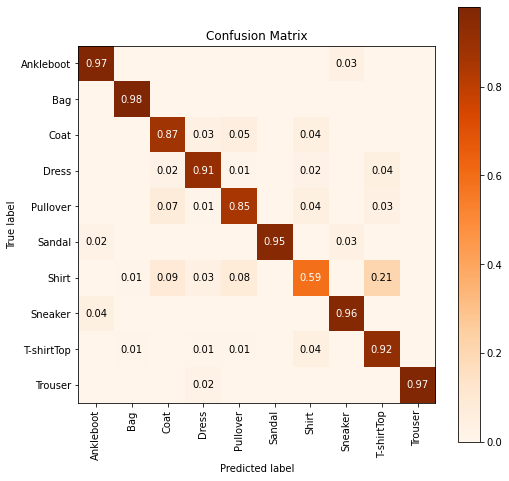

In [ ]:
PrintConfusion(simple_cnn_model, test_data_loader)

In [ ]:
d = iter(test_data_loader)
images, labels = d.next()

In [ ]:
d = iter(test_data_loader_RGB)
images_transfer, labels_transfer = d.next()
'''images_transfer = images_transfer.to(cuda)
labels_transfer = labels_transfer.to(cuda)'''


'images_transfer = images_transfer.to(cuda)\nlabels_transfer = labels_transfer.to(cuda)'

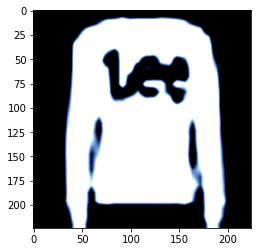

In [ ]:
plt.imshow(np.transpose(images_transfer[1].cpu().numpy(), (1,2,0)))

In [ ]:
#plot normal
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.gray()
    plt.imshow(np.stack((test_data[i][0].reshape(28,28), test_data[i][0].reshape(28,28),test_data[i][0].reshape(28,28)), axis=2), cmap="gray")
    plt.xlabel(label_names[test_data[i][1]])
plt.show()

**Overview Feature Based Explanation Methods**

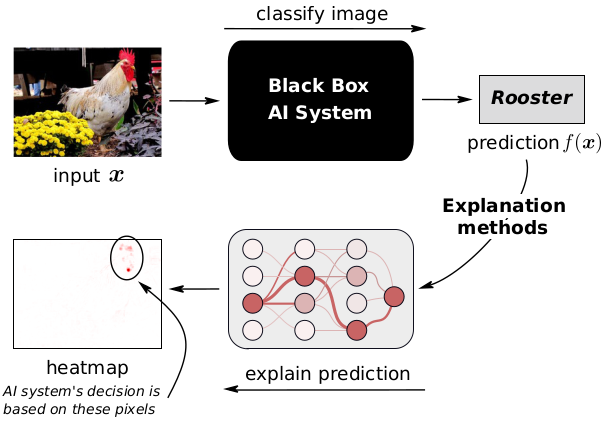

In [ ]:
Image('/content/overview_new.png')

**Overview Layerwise Relevance Propagation**

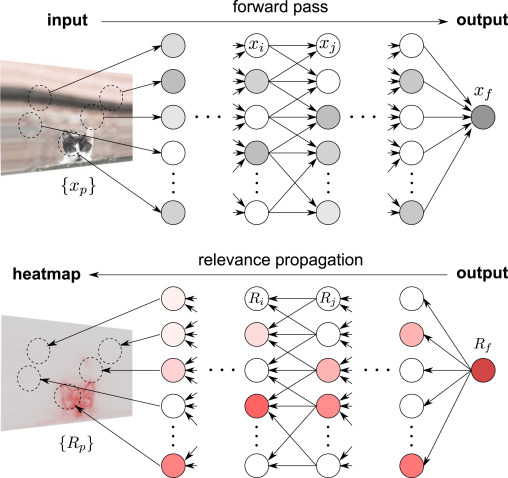

In [ ]:
Image('/content/LRP.jpeg')

5
5


/content/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


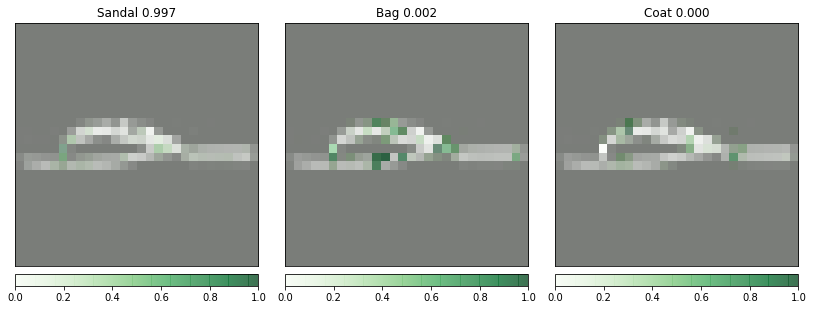

In [ ]:
#sandals: 8 11
#bag 18 30
im = 8

tensor = images[im]

# Feed input through network.
prediction = simple_cnn_model(tensor).argmax().item()

org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

#get best, second best and worst label prediction
predictions = simple_cnn_model(tensor).squeeze()
values = torch.softmax(predictions, 0)
sorted_values, sorted_idx = torch.topk(values, 10)
sorted_values.cpu().squeeze()
best_worst_class_values = [sorted_values[i] for i in [0,1,-1]]
best_worst_class_idx = [sorted_idx[i] for i in [0,1,-1]]

best_worst_class_idx
#LRP explanation for best, second best and worst label prediction
lrp= LRP(simple_cnn_model)

figure, axes = plt.subplots(1, 3, figsize=(3 * 3.8, 2 * 3.8))
	
for axis, i, v in zip(axes.flatten(),best_worst_class_idx,best_worst_class_values):
  attribution = (lrp.attribute(tensor, target=int(i)).detach().numpy().squeeze())
  #vis.visualize_image_attr(None, org_image, method="original_image")
 
  vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           #method="heat_map", 
                           method="blended_heat_map",sign="positive",plt_fig_axis=(figure, axis),
                           show_colorbar=True, 
                           use_pyplot=False)
	
  axis.set_title(label_names[i.item()] + f" {v:0.3f}")
	
plt.tight_layout()
	
figure.savefig("lrp.svg", bbox_inches="tight")

**Saliency Transfer Model**

5
5


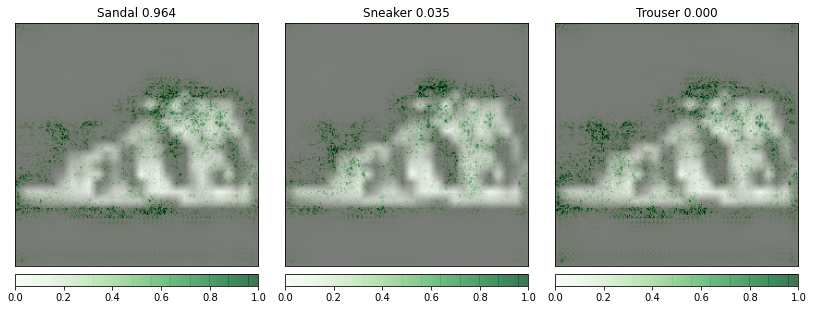

In [ ]:
#sandals: 8 11
#bag 18 30
im = 11

tensor = images_transfer[im][None,:,:,:]

# Feed input through network.
prediction = model_transfer(tensor).argmax().item()
print(prediction)
print(labels_transfer[im].item())
org_image=np.transpose(images_transfer[im].cpu().numpy(), (1,2,0))

#get best, second best and worst label prediction
predictions = model_transfer(tensor).squeeze()
values = torch.softmax(predictions, 0)
sorted_values, sorted_idx = torch.topk(values, 10)
sorted_values.cpu().squeeze()
best_worst_class_values = [sorted_values[i] for i in [0,1,-1]]
best_worst_class_idx = [sorted_idx[i] for i in [0,1,-1]]

best_worst_class_idx
#LRP explanation for best, second best and worst label prediction
saliency= Saliency(model_transfer)

figure, axes = plt.subplots(1, 3, figsize=(3 * 3.8, 2 * 3.8))
	
for axis, i, v in zip(axes.flatten(),best_worst_class_idx,best_worst_class_values):
  attribution = (saliency.attribute(tensor, target=int(i)).cpu().detach().numpy().squeeze())
  #vis.visualize_image_attr(None, org_image, method="original_image")
 
  vis.visualize_image_attr(np.transpose(attribution, (1,2,0)),original_image=org_image,
                           #method="heat_map", 
                           method="blended_heat_map",sign="positive",plt_fig_axis=(figure, axis),
                           show_colorbar=True, 
                           use_pyplot=False)
	
  axis.set_title(label_names[i.item()] + f" {v:0.3f}")
	
plt.tight_layout()
	
figure.savefig("lrp.svg", bbox_inches="tight")

In [ ]:
im = 58

tensor = images[im]
model = simple_cnn_model
prediction = model(tensor).argmax().item()
print(prediction)
print(labels[im].item())


org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

methods = [
	  (Saliency(model), {}),
    (LRP(model), {}),
    (DeepLift(model), {}),
	  (GuidedBackprop(model), {}),
    (IntegratedGradients(model), {}),
    (GuidedGradCam(model, layer=list(model.modules())[1:][1]), {}),
    (Lime(model), {}),
	]

figure, axes = plt.subplots(2, 4, figsize=(3 * 3.8, 2 * 3.8))
plt.imshow(np.stack((org_image.reshape(28,28), org_image.reshape(28,28),org_image.reshape(28,28)), axis=2), cmap="gray")

for axis, (method, params) in zip(axes.flatten(), methods):
  attribution = (method.attribute(images[im:im+1], target=labels[im:im+1], 
                                  **params).cpu().detach().numpy().squeeze())
	
  vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           method="blended_heat_map",sign="positive",plt_fig_axis=(figure, axis),
                           show_colorbar=True,
                           use_pyplot=False,)

  
  axis.set_title(type(method).__name__)
	
 
plt.tight_layout()
	
figure.savefig("before_attack.png", bbox_inches="tight")

8
8


/content/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/content/captum/captum/attr/_core/deep_lift.py:338: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/content/captum/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


**Attack (Fast Gradient Sign Method)**

In [ ]:
#untargeted attack
classifier = PyTorchClassifier(
        model=model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(model.parameters(), lr=1e-3),
        input_shape=(1, 26, 26),
        nb_classes=10
    )

attack = FastGradientMethod(estimator=classifier, eps=0.2)
imgs_adv = attack.generate(x=Tensor.cpu(tensor).numpy())

In [ ]:
#explain again
tensor = torch.from_numpy(imgs_adv)




figure, axes = plt.subplots(1, 4, figsize=(3 * 3.8, 2 * 3.8))
for axis, (method, params) in zip(axes.flatten(), methods):
  attribution = (method.attribute(tensor, target=prediction, **params).cpu().detach().numpy().squeeze())
	
  vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           method="blended_heat_map",sign="positive",plt_fig_axis=(figure, axis),
                           show_colorbar=True,
                           use_pyplot=False,)

  
  axis.set_title(type(method).__name__)
	
 
plt.tight_layout()
	
figure.savefig("after_attack.png", bbox_inches="tight")

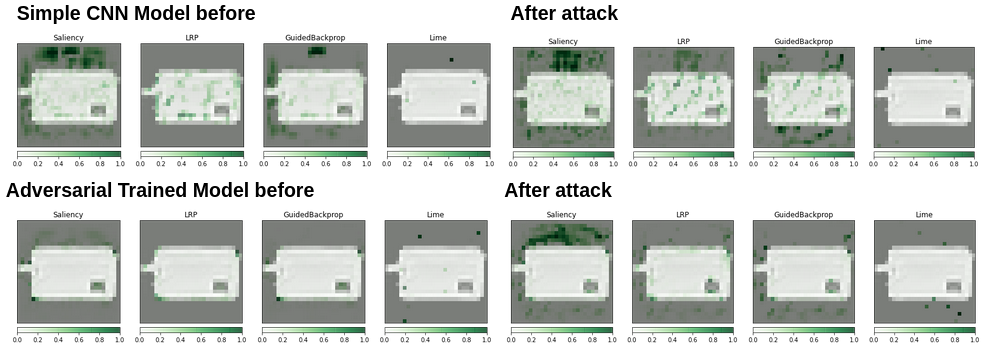

In [3]:
Image('/content/new_attack_before_after.png')